In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Handing Imbalance Dataset
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score

# Warnings
import warnings as ws
ws.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)

#### Load Dataset

In [3]:
# Load data
train_split = pd.read_csv('train_split.csv', index_col=0)
val_split = pd.read_csv('val_split.csv', index_col=0)
test_split = pd.read_csv('test_split.csv', index_col=0)

# Separate X and y
X_train = train_split.drop(columns=['FIRST_DECISION'])
y_train = train_split['FIRST_DECISION']
# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_val = val_split.drop(columns=['FIRST_DECISION'])
y_val = val_split['FIRST_DECISION']

X_test = test_split.drop(columns=['FIRST_DECISION'])
y_test = test_split['FIRST_DECISION']

### Model Building

**LogisticRegression** model with multiple technique to handle the imbalanced H1B dataset. 

**Metrics :**

For the H1B dataset, accuracy is not a reliable metric due to class imbalance. Our main concern is reducing Type II errors — cases where we predict "Approved" but the true outcome is "Denied." This mistake could have serious consequences, like someone not preparing a backup plan. So, we prioritize Recall, especially for the "Denied" class, to catch as many potential denials as possible. That said, we also care about F1 score to maintain a balance between catching denials (Recall) and avoiding too many false alarms (Precision).

In [4]:
# Train Test Ratio
def train_test_ratio(y_train):
    
    class_0 = np.round(y_train.value_counts()[0]/len(y_train),3)
    class_1 = np.round(y_train.value_counts()[1]/len(y_train),3)
    
    len_class_0 = y_train.value_counts()[0]
    len_class_1 = y_train.value_counts()[1]
    
    print('-'*25)
    print('Train - Test Ratio :')
    print('-'*25)
    print('Denied 0 : {} : {} %'.format(len_class_0,class_0))
    print('Approved 1 : {} : {} %'.format(len_class_1,class_1))

In [5]:
# Normalized Confusion Matrix
def get_norm_cnf_matrix(y_test, y_pred):

    # Noramalized Confusion Matrix
    y_test_0 = y_test.value_counts()[0]
    y_test_1 = y_test.value_counts()[1]    
    cnf_norm_matrix = np.array([[1.0 / y_test_0,1.0/y_test_0],[1.0/y_test_1,1.0/y_test_1]])
    norm_cnf_matrix = np.around(confusion_matrix(y_test, y_pred) * cnf_norm_matrix,3)
    
    return(norm_cnf_matrix)

In [6]:
# Confusion Matrix
def plt_cnf_matrix(y_test,y_pred):
    
    # Confusion Matrix`
    cnf_matrix = confusion_matrix(y_test, y_pred)    
    
    # Normalized Confusion Matrix
    norm_cnf_matrix = get_norm_cnf_matrix(y_test, y_pred)
    
    # Confusion Matrix plot
    plt.figure(figsize = (15,3))
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.subplot(1,2,1)
    sns.heatmap(cnf_matrix, annot = True, fmt = 'g', cmap = plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    
    # Noramalized Confusion Matrix Plot
    plt.subplot(1,2,2)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.heatmap(norm_cnf_matrix, annot = True, fmt = 'g', cmap = plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')  
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    print('-'*25)
    print('Classification Report')
    print('-'*25)
    print(classification_report(y_test, y_pred))

### 1. Logistic Regression
#### Base Model

-------------------------
Train - Test Ratio :
-------------------------
Denied 0 : 6054 : 0.032 %
Approved 1 : 183959 : 0.968 %
None


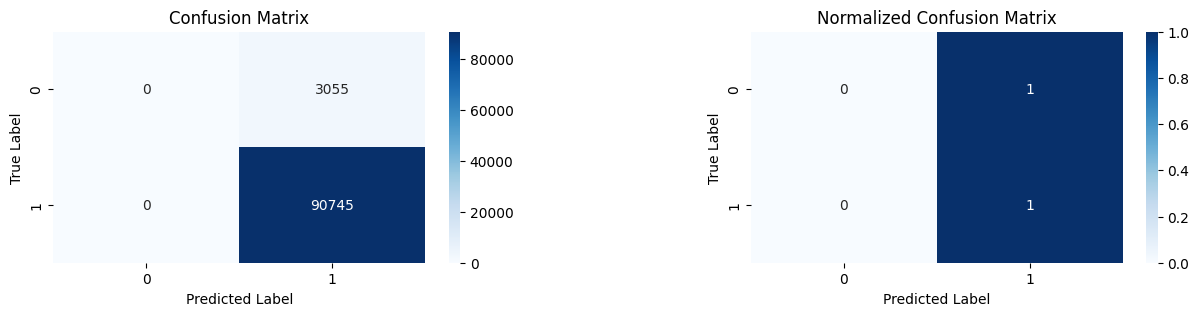

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3055
           1       0.97      1.00      0.98     90745

    accuracy                           0.97     93800
   macro avg       0.48      0.50      0.49     93800
weighted avg       0.94      0.97      0.95     93800



In [7]:
print(train_test_ratio(y_train))

base_model = LogisticRegression()
base_model.fit(X_train, y_train)

y_pred_base = base_model.predict(X_val)
plt_cnf_matrix(y_val, y_pred_base)

**Rcall** for base model class 0 is **0.00**. 

#### Under Sampling :

This is the technique which reduce majority class to reach minoriy class level. 

-------------------------
Train - Test Ratio :
-------------------------
Denied 0 : 6054 : 0.5 %
Approved 1 : 6054 : 0.5 %
None


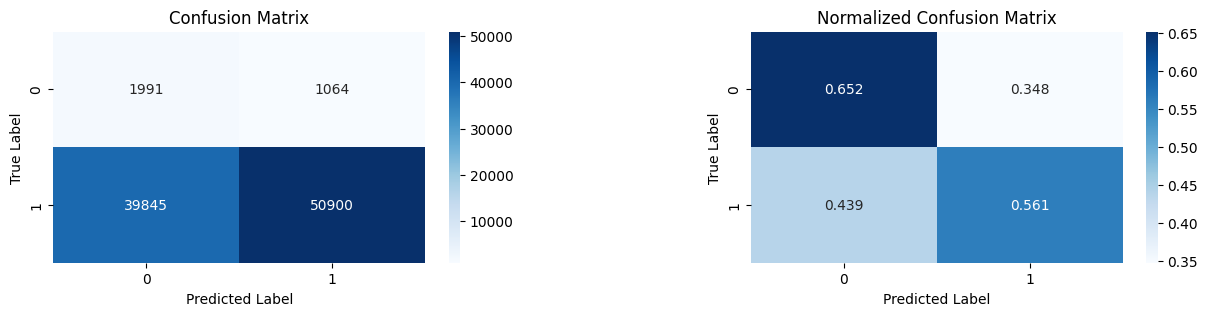

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.65      0.09      3055
           1       0.98      0.56      0.71     90745

    accuracy                           0.56     93800
   macro avg       0.51      0.61      0.40     93800
weighted avg       0.95      0.56      0.69     93800



In [8]:
from imblearn.under_sampling import RandomUnderSampler  

under_sampler = RandomUnderSampler()
X_under, Y_under = under_sampler.fit_resample(X_train, y_train)
print(train_test_ratio(Y_under))

under_sampling_model = LogisticRegression()
under_sampling_model.fit(X_under, Y_under)

y_pred_under = under_sampling_model.predict(X_val)
plt_cnf_matrix(y_val, y_pred_under)

Here **Recall** of undersampling class 0 is 0.65. It seems much better than base model (0.00).

#### Over Sampling

Here we replicate minority samples till reach majority count

-------------------------
Train - Test Ratio :
-------------------------
Denied 0 : 183959 : 0.5 %
Approved 1 : 183959 : 0.5 %
None


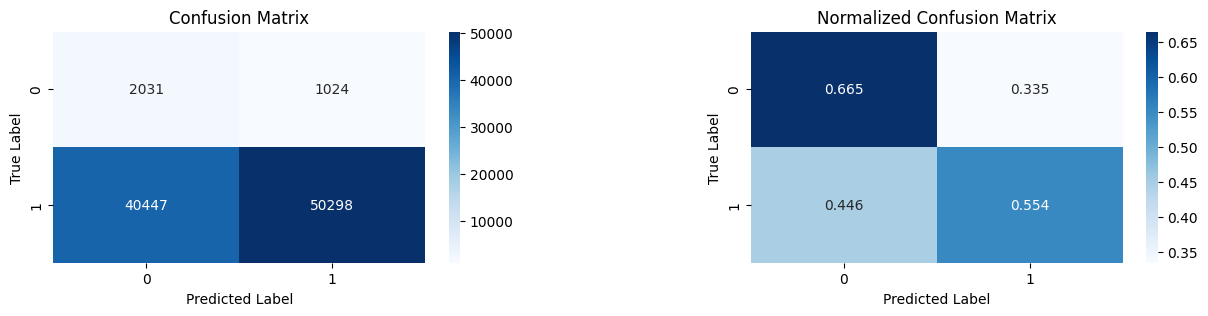

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.66      0.09      3055
           1       0.98      0.55      0.71     90745

    accuracy                           0.56     93800
   macro avg       0.51      0.61      0.40     93800
weighted avg       0.95      0.56      0.69     93800



In [9]:
over_sampling = RandomOverSampler(random_state = 42)
X_over, Y_over = over_sampling.fit_resample(X_train,y_train)
print(train_test_ratio(Y_over))

over_sampling_model = LogisticRegression()
over_sampling_model.fit(X_over, Y_over)

y_pred_over = over_sampling_model.predict(X_val)
plt_cnf_matrix(y_val, y_pred_over)

**Recall** for over sampling is 0.66. 

#### Balanced Class Weight

This is technique gives more weight to minority class. 

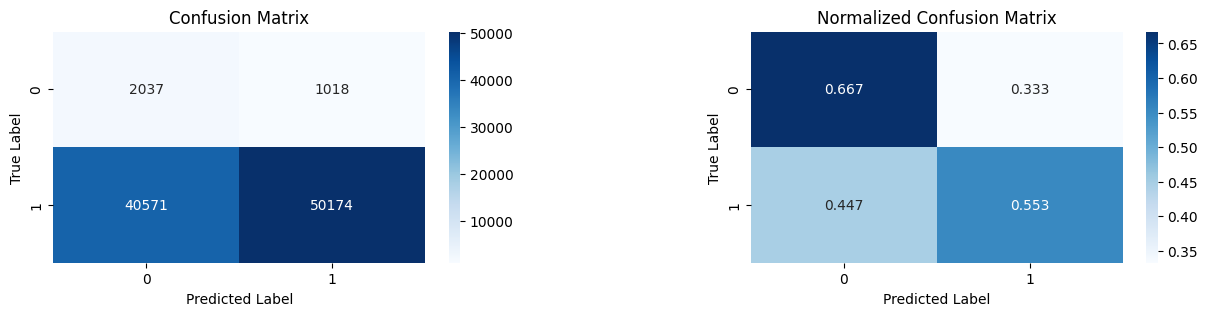

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.67      0.09      3055
           1       0.98      0.55      0.71     90745

    accuracy                           0.56     93800
   macro avg       0.51      0.61      0.40     93800
weighted avg       0.95      0.56      0.69     93800



In [10]:
balanced_model = LogisticRegression(class_weight='balanced')
balanced_model.fit(X_train, y_train)

y_pred_bal = balanced_model.predict(X_val)
plt_cnf_matrix(y_val, y_pred_bal)

**Recall** of Balanced model is 0.67.

In [11]:
models = []
models.append(('Base Model', base_model))
models.append(('Under Sampling Model', under_sampling_model))
models.append(('Over Sampling Model', over_sampling_model))
models.append(('Balanced Model', balanced_model))

In [12]:
def model_evaluation(y_train, y_pred):
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(y_train, y_pred)
    
    # Confusion Matrix Parameters
    tp = cnf_matrix[1,1] # True Poistive
    tn = cnf_matrix[0,0] # True Negative
    fn = cnf_matrix[1,0] # False Negative
    fp = cnf_matrix[0,1] # False Positive
    
    # True Positive Rate
    """ Howmany of the True correctly classified as True """
    tpr = tp/(tp+fn)
    
    # True Negative Rate
    """ Howmany of the False correctly classifier as False """
    tnr = tn/(tn+fp)
    
    # Precision (for True)
    """ Howmany of the predicted True actually True """
    precision = tp/(tp+fp)
    
    # F1 Score
    """ Weighted avg of Precision and Recall """
    fscore = f1_score(y_train, y_pred)
    
    # Accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)

    return(tp,tn,fp,fn,tpr,tnr,precision,fscore,acc)

In [13]:
col = ['Model','TP','TN','FP','FN','TPR','TNR','Precision','F1 Score','Accuracy']
result = pd.DataFrame(columns = col)

i = 0
for name, model in models:
   
    Y_pred = model.predict(X_test)
    tp,tn,fp,fn,tpr,tnr,precision,fscore,acc = model_evaluation(y_test, Y_pred)
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    result.loc[i] = [name,tp,tn,fp,fn,tpr,tnr,precision,fscore,acc]
    i+=1
    
result

Model     TP    TN    FP     FN   TPR   TNR  Precision  \
0            Base Model  89139     0  1951      0 1.000 0.000      0.979   
1  Under Sampling Model  48954  1317   634  40185 0.549 0.675      0.987   
2   Over Sampling Model  48681  1339   612  40458 0.546 0.686      0.988   
3        Balanced Model  48721  1334   617  40418 0.547 0.684      0.987   

   F1 Score  Accuracy  
0     0.989     0.979  
1     0.706     0.552  
2     0.703     0.549  
3     0.704     0.550

1. **Base Model**           : May gives better accuracy, But TNR is 0.
2. **Under Sampling Model** : Misses a lot of denied, but is very precise.
3. **Over Sampling Model**  : Slightly better in TNR and slightly more balanced than Under Sampling.
4. **Balanced Model**       : Best F1 score overall - most balanced between precision and recall. Likely the best trade-off.



### 2. Random Forest Model

Random Forest (No Tuning)


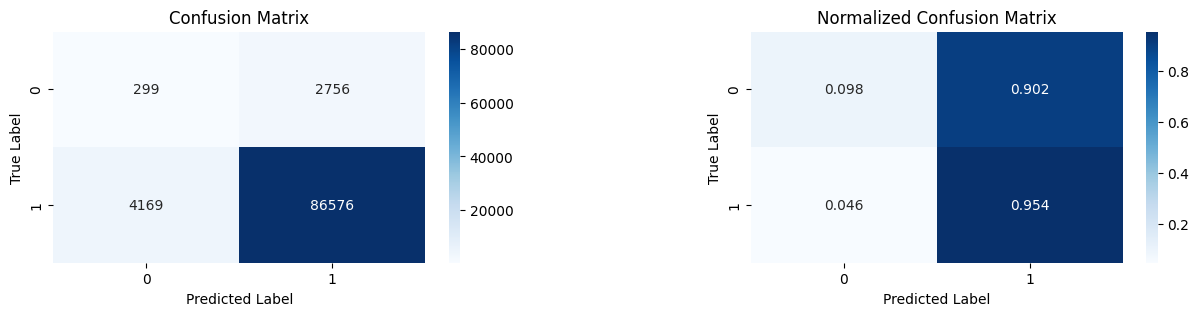

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.07      0.10      0.08      3055
           1       0.97      0.95      0.96     90745

    accuracy                           0.93     93800
   macro avg       0.52      0.53      0.52     93800
weighted avg       0.94      0.93      0.93     93800

Random Forest (No Tuning w/ SMOTE)


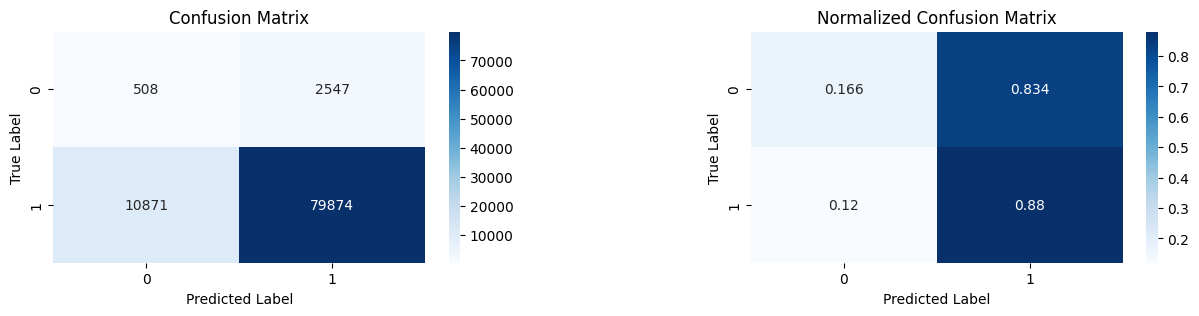

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.04      0.17      0.07      3055
           1       0.97      0.88      0.92     90745

    accuracy                           0.86     93800
   macro avg       0.51      0.52      0.50     93800
weighted avg       0.94      0.86      0.89     93800

Random Forest (Tuned)
Best RF Parameters: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}


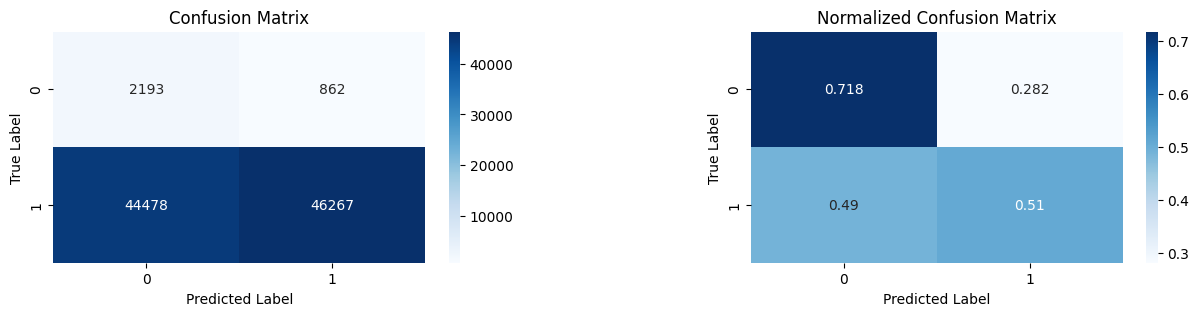

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.72      0.09      3055
           1       0.98      0.51      0.67     90745

    accuracy                           0.52     93800
   macro avg       0.51      0.61      0.38     93800
weighted avg       0.95      0.52      0.65     93800

Random Forest (Tuned w/ SMOTE)
Best RF Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50}


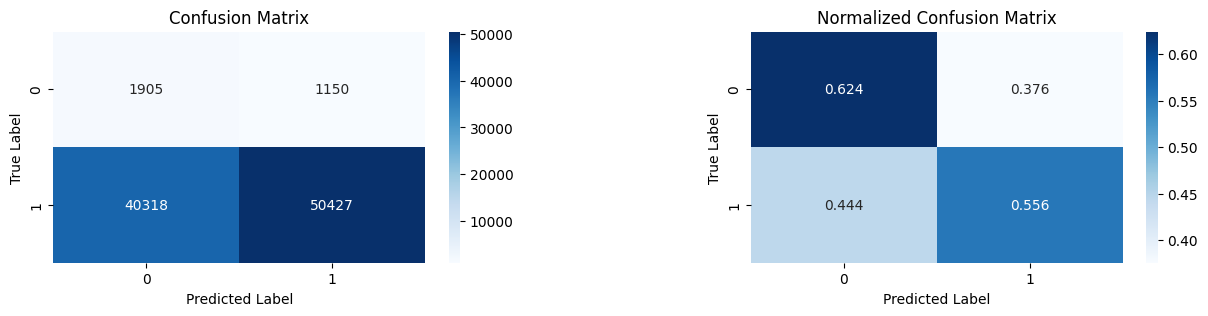

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.62      0.08      3055
           1       0.98      0.56      0.71     90745

    accuracy                           0.56     93800
   macro avg       0.51      0.59      0.40     93800
weighted avg       0.95      0.56      0.69     93800



In [14]:
# No tuning
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
print("Random Forest (No Tuning)")
plt_cnf_matrix(y_val, rf.predict(X_val))
# With SMOTE
rf_sm = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
print("Random Forest (No Tuning w/ SMOTE)")
plt_cnf_matrix(y_val, rf_sm.predict(X_val))

# With tuning
rf_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 8],
    'min_samples_split': [2, 10]
}
rf_cv = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), rf_grid, cv=3)
rf_cv.fit(X_train, y_train)
print("Random Forest (Tuned)")
print("Best RF Parameters:", rf_cv.best_params_)
plt_cnf_matrix(y_val, rf_cv.predict(X_val))
# With SMOTE
rf_cv_sm = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), rf_grid, cv=3)
rf_cv_sm.fit(X_train_sm, y_train_sm)
print("Random Forest (Tuned w/ SMOTE)")
print("Best RF Parameters:", rf_cv_sm.best_params_)
plt_cnf_matrix(y_val, rf_cv_sm.predict(X_val))

### 3. XGBoost Model

XGBoost (No Tuning)


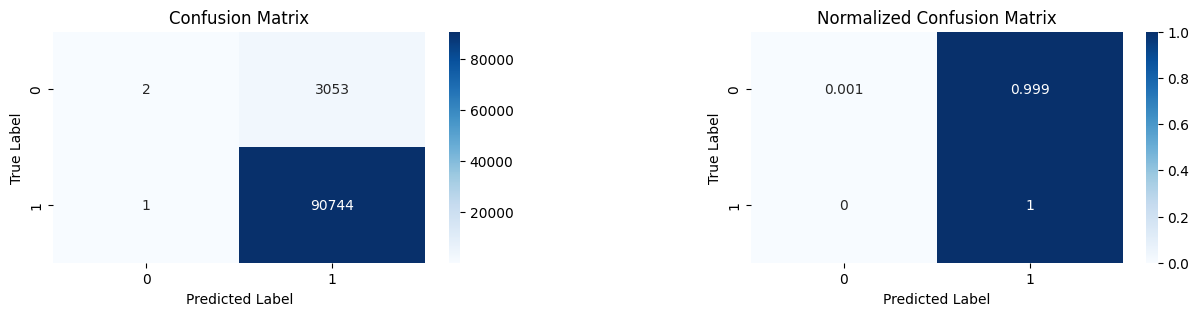

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      3055
           1       0.97      1.00      0.98     90745

    accuracy                           0.97     93800
   macro avg       0.82      0.50      0.49     93800
weighted avg       0.96      0.97      0.95     93800

XGBoost (No Tuning w/ SMOTE)


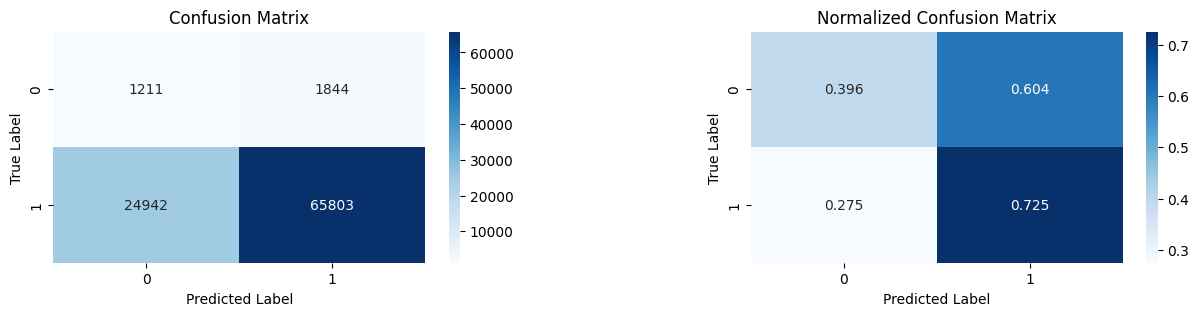

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.40      0.08      3055
           1       0.97      0.73      0.83     90745

    accuracy                           0.71     93800
   macro avg       0.51      0.56      0.46     93800
weighted avg       0.94      0.71      0.81     93800

XGBoost (Tuned)
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


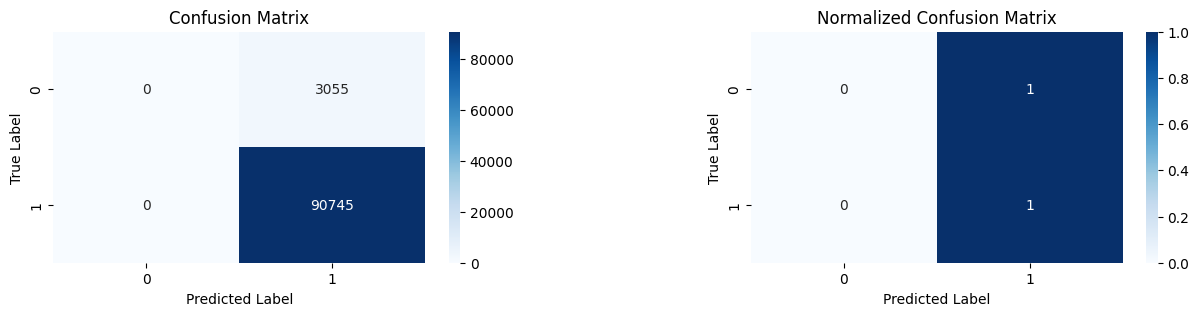

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3055
           1       0.97      1.00      0.98     90745

    accuracy                           0.97     93800
   macro avg       0.48      0.50      0.49     93800
weighted avg       0.94      0.97      0.95     93800

XGBoost (Tuned w/ SMOTE)
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


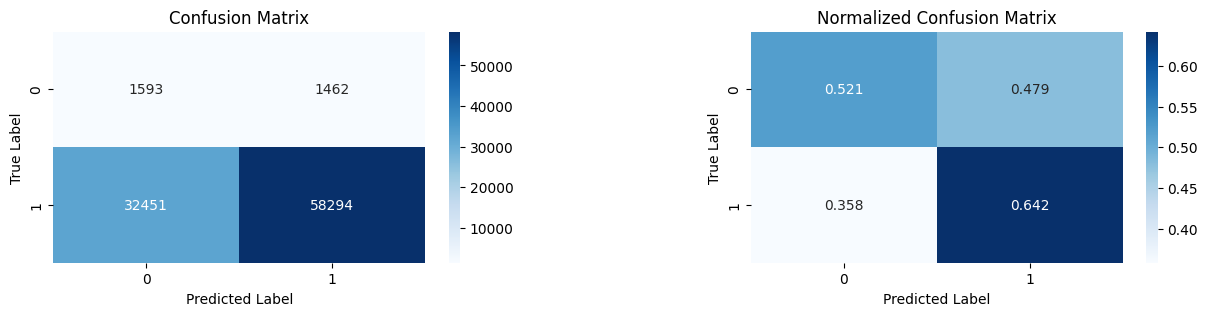

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.52      0.09      3055
           1       0.98      0.64      0.77     90745

    accuracy                           0.64     93800
   macro avg       0.51      0.58      0.43     93800
weighted avg       0.95      0.64      0.75     93800



In [15]:
# scale_pos_weight = (# approved / # denied)
pos_weight = (y_train == 1).sum() / (y_train == 0).sum()
pos_weight_sm = (y_train_sm == 1).sum() / (y_train_sm == 0).sum()

# No tuning
xg = XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight, random_state=42)
xg.fit(X_train, y_train)
print("XGBoost (No Tuning)")
plt_cnf_matrix(y_val, xg.predict(X_val))
# With SMOTE
xg_sm = XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight_sm, random_state=42)
xg_sm.fit(X_train_sm, y_train_sm)
print("XGBoost (No Tuning w/ SMOTE)")
plt_cnf_matrix(y_val, xg_sm.predict(X_val))

# With tuning
xg_grid = {
    'max_depth': [3, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01]
}
xg_cv = GridSearchCV(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight, random_state=42),
    xg_grid, cv=3
)
xg_cv.fit(X_train, y_train)
print("XGBoost (Tuned)")
print("Best XGBoost Parameters:", xg_cv.best_params_)
plt_cnf_matrix(y_val, xg_cv.predict(X_val))
# With SMOTE
xg_cv_sm = GridSearchCV(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight_sm, random_state=42),
    xg_grid, cv=3
)
xg_cv_sm.fit(X_train_sm, y_train_sm)
print("XGBoost (Tuned w/ SMOTE)")
print("Best XGBoost Parameters:", xg_cv_sm.best_params_)
plt_cnf_matrix(y_val, xg_cv_sm.predict(X_val))

### 3. CatBoost Model

CatBoost (No Tuning)


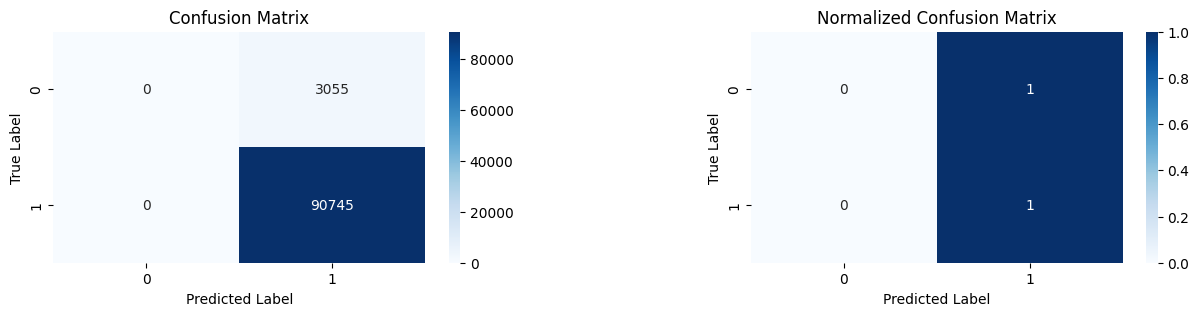

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3055
           1       0.97      1.00      0.98     90745

    accuracy                           0.97     93800
   macro avg       0.48      0.50      0.49     93800
weighted avg       0.94      0.97      0.95     93800

CatBoost (No Tuning w/ SMOTE)


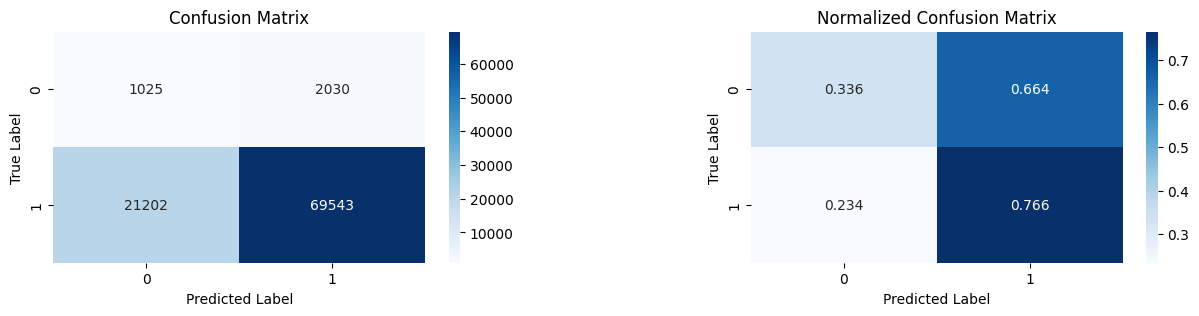

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.34      0.08      3055
           1       0.97      0.77      0.86     90745

    accuracy                           0.75     93800
   macro avg       0.51      0.55      0.47     93800
weighted avg       0.94      0.75      0.83     93800

CatBoost (Tuned)
Best CatBoost Parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


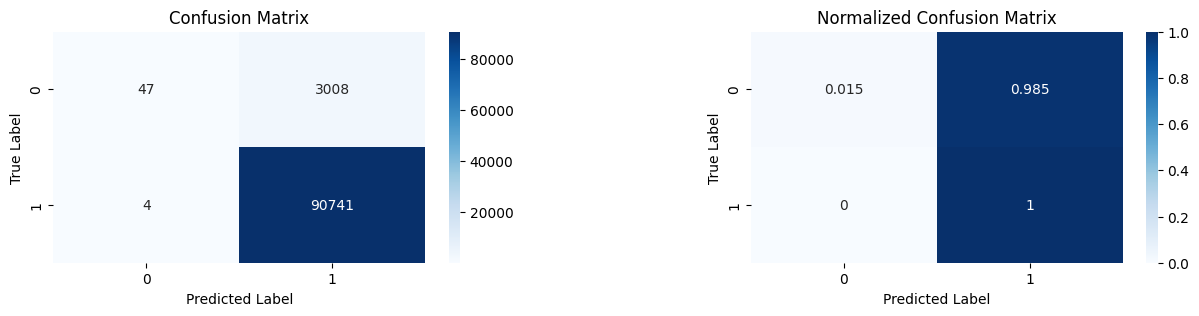

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.02      0.03      3055
           1       0.97      1.00      0.98     90745

    accuracy                           0.97     93800
   macro avg       0.94      0.51      0.51     93800
weighted avg       0.97      0.97      0.95     93800

CatBoost (Tuned w/ SMOTE)
Best CatBoost Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


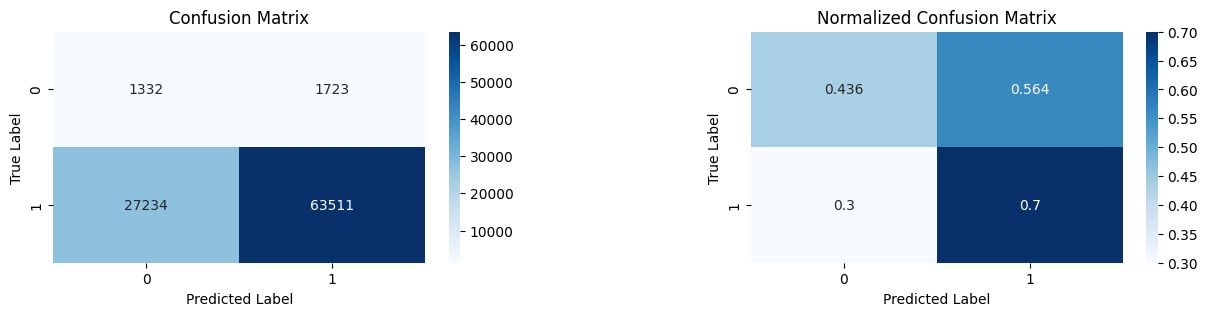

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.05      0.44      0.08      3055
           1       0.97      0.70      0.81     90745

    accuracy                           0.69     93800
   macro avg       0.51      0.57      0.45     93800
weighted avg       0.94      0.69      0.79     93800



In [16]:
# No tuning
cat = CatBoostClassifier(verbose=0, scale_pos_weight=pos_weight, random_state=42)
cat.fit(X_train, y_train)
print("CatBoost (No Tuning)")
plt_cnf_matrix(y_val, cat.predict(X_val))
# With SMOTE
cat_sm = CatBoostClassifier(verbose=0, scale_pos_weight=pos_weight_sm, random_state=42)
cat_sm.fit(X_train_sm, y_train_sm)
print("CatBoost (No Tuning w/ SMOTE)")
plt_cnf_matrix(y_val, cat_sm.predict(X_val))

# With tuning
cat_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 200]
}
cat_cv = GridSearchCV(
    CatBoostClassifier(verbose=0, scale_pos_weight=pos_weight, random_state=42),
    cat_grid, cv=3
)
cat_cv.fit(X_train, y_train)
print("CatBoost (Tuned)")
print("Best CatBoost Parameters:", cat_cv.best_params_)
cat_cv.fit(X_train_sm, y_train_sm)
plt_cnf_matrix(y_val, cat_cv.predict(X_val))
# With SMOTE
cat_cv_sm = GridSearchCV(
    CatBoostClassifier(verbose=0, scale_pos_weight=pos_weight_sm, random_state=42),
    cat_grid, cv=3
)
cat_cv_sm.fit(X_train_sm, y_train_sm)
print("CatBoost (Tuned w/ SMOTE)")
print("Best CatBoost Parameters:", cat_cv_sm.best_params_)
cat_cv.fit(X_train_sm, y_train_sm)
plt_cnf_matrix(y_val, cat_cv_sm.predict(X_val))

In [17]:
models = []
models.append(('Random Forest Model (Tuned w/ SMOTE)', rf_cv_sm))
models.append(('XGBoost Model (Tuned w/ SMOTE)', xg_cv_sm))
models.append(('CatBoost Model (Tuned w/ SMOTE)', cat_cv_sm))

In [18]:
col = ['Model','TP','TN','FP','FN','TPR','TNR','Precision','F1 Score','Accuracy']
result = pd.DataFrame(columns = col)

i = 0
for name, model in models:
   
    Y_pred = model.predict(X_test)
    tp,tn,fp,fn,tpr,tnr,precision,fscore,acc = model_evaluation(y_test, Y_pred)
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    result.loc[i] = [name,tp,tn,fp,fn,tpr,tnr,precision,fscore,acc]
    i+=1
    
result

Model     TP    TN    FP     FN   TPR   TNR  \
0  Random Forest Model (Tuned w/ SMOTE)  52440  1146   805  36699 0.588 0.587   
1        XGBoost Model (Tuned w/ SMOTE)  59483   967   984  29656 0.667 0.496   
2       CatBoost Model (Tuned w/ SMOTE)  63992   828  1123  25147 0.718 0.424   

   Precision  F1 Score  Accuracy  
0      0.985     0.737     0.588  
1      0.984     0.795     0.664  
2      0.983     0.830     0.712

1. **Random Forest Model** : Most balanced between approvals and denials. While F1 (0.737) and accuracy (0.588) are slightly lower, it has the highest TNR (0.587), making it the best at catching denied cases — ideal when reducing false negatives is the goal.
2. **XGBoost Model** : Offers strong accuracy (0.664) and F1 score (0.795), with a higher TPR (0.667). Slight drop in TNR (0.496), so it performs better for approvals, but is slightly worse than Random Forest at identifying denials.
3. **CatBoost Model**  : Highest F1 (0.830) and TPR (0.718), meaning it’s best at catching approvals, but the lowest TNR (0.424) makes it the weakest at identifying denials.

### Important Features

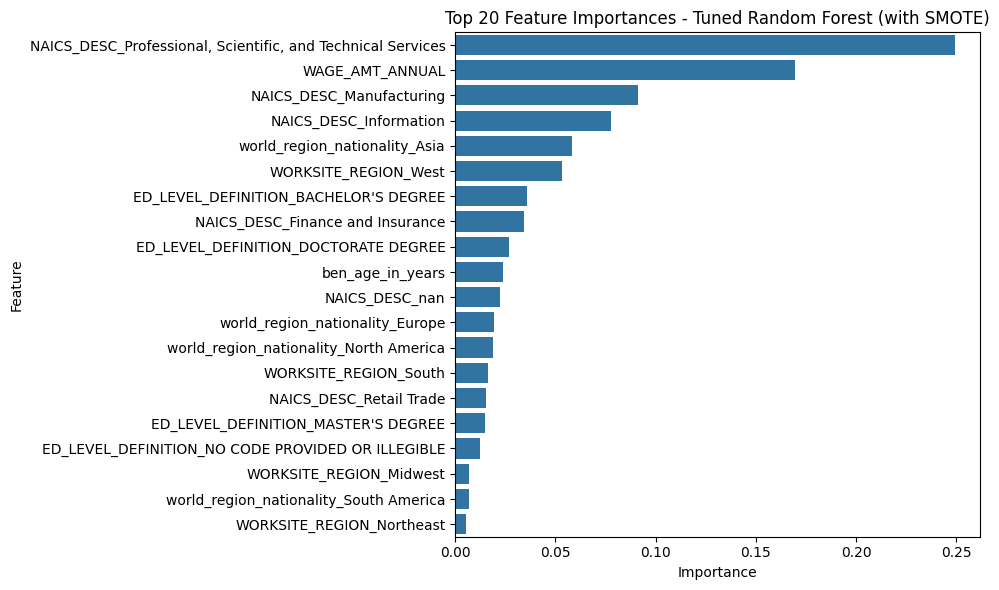

In [19]:
# Get feature importances from the best estimator
importances = rf_cv_sm.best_estimator_.feature_importances_

# Create a DataFrame for visualization
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances - Tuned Random Forest (with SMOTE)')
plt.tight_layout()
plt.show()

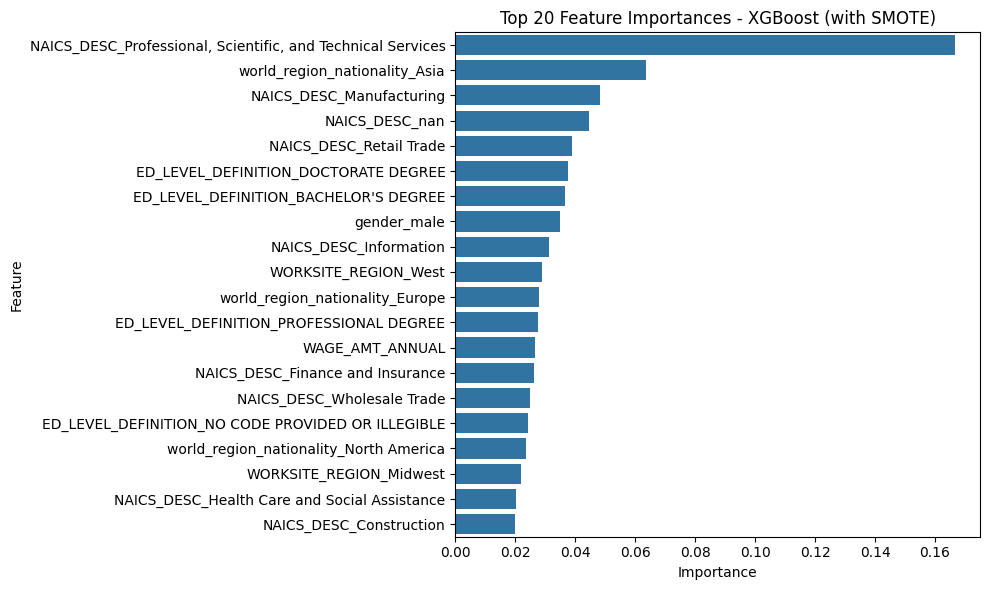

In [20]:
# XGBoost feature importances
importances_xg = xg_cv_sm.best_estimator_.feature_importances_

feat_importance_xg = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_xg
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_xg.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances - XGBoost (with SMOTE)')
plt.tight_layout()
plt.show()

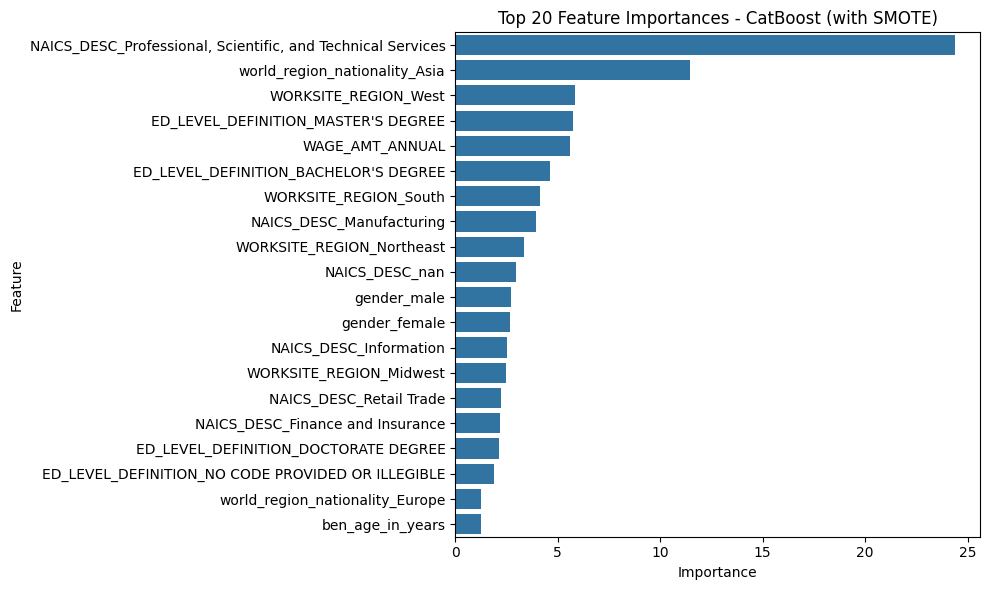

In [21]:
# CatBoost feature importances
importances_cat = cat_cv_sm.best_estimator_.get_feature_importance()

feat_importance_cat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_cat
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_cat.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances - CatBoost (with SMOTE)')
plt.tight_layout()
plt.show()
